In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1
p["errorbar.capsize"] = 2


In [3]:
def process(filename, headers, datas):
    header = np.loadtxt(filename, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
    headers.append(header)

    data = np.loadtxt(filename, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append(np.array((V_in_combined, I_out_combined, I_out_std_combined)))

In [4]:
all_headers = [[], [], [], []]
all_datas = [[], [], [], []]
for run in glob('../data/position_grill/*'):
    process(run, all_headers[0], all_datas[0])
for run in glob('../data/position_pression/1.3e-3/*'):
    process(run, all_headers[1], all_datas[1])
for run in glob('../data/position_pression/6.9e-4/*'):
    process(run, all_headers[2], all_datas[2])
for run in glob('../data/position_pression/8.3e-3/*'):
    process(run, all_headers[3], all_datas[3])
all_headers[0][0][0], all_headers[1][0][0]

(np.float64(0.005), np.float64(0.0013))

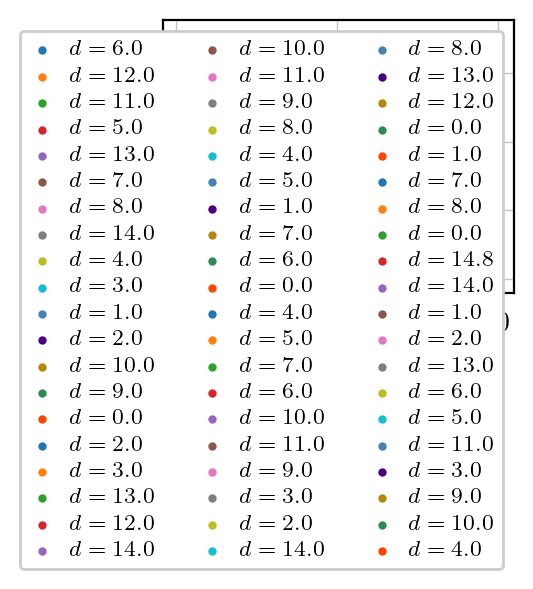

In [5]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for headers, datas in zip(all_headers, all_datas):
    for header, data in zip(headers, datas):
        p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
        V_in, I_out, I_out_std = data

        plt.scatter(V_in, I_out, label=f"$d = {d}$")

plt.legend(ncols=3, fontsize=8, markerscale=4)

## Find V_{sp}, ln(I_{es})

In [6]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

Fit 0,0
3.96+/-0.04 0.00371+/-0.00004
T_e_run = (1.80±0.06)×10⁴, T_run = (1.55±0.05)×10⁰, n_e_run = (3.53±0.07)×10¹⁶
Fit 0,1
3.87+/-0.05 0.003069+/-0.000033
T_e_run = (1.98±0.06)×10⁴, T_run = (1.71±0.05)×10⁰, n_e_run = (2.78±0.05)×10¹⁶
Fit 0,2
3.92+/-0.04 0.003281+/-0.000035
T_e_run = (1.93±0.06)×10⁴, T_run = (1.66±0.05)×10⁰, n_e_run = (3.01±0.05)×10¹⁶
Fit 0,3
4.15+/-0.04 0.00386+/-0.00004
T_e_run = (1.92±0.06)×10⁴, T_run = (1.66±0.05)×10⁰, n_e_run = (3.56±0.06)×10¹⁶
Fit 0,4
3.76+/-0.05 0.002772+/-0.000027
T_e_run = (1.98±0.06)×10⁴, T_run = (1.71±0.05)×10⁰, n_e_run = (2.51±0.04)×10¹⁶
Fit 0,5
4.04+/-0.04 0.00374+/-0.00004
T_e_run = (1.89±0.06)×10⁴, T_run = (1.63±0.05)×10⁰, n_e_run = (3.47±0.06)×10¹⁶
Fit 0,6
4.04+/-0.04 0.00368+/-0.00005
T_e_run = (1.90±0.06)×10⁴, T_run = (1.64±0.05)×10⁰, n_e_run = (3.40±0.07)×10¹⁶
Fit 0,7
3.54+/-0.10 0.002118+/-0.000024
T_e_run = (2.13±0.07)×10⁴, T_run = (1.84±0.06)×10⁰, n_e_run = (1.85±0.03)×10¹⁶
Fit 0,8
4.23+/-0.05 0.00389+/-0.00005
T_e_run = (1.96±0.

/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_4700/2660186526.py:45: RuntimeWarning: invalid value encountered in log
  dydx = np.gradient(np.log(I_out), V_in)
/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_4700/2660186526.py:60: RuntimeWarning: invalid value encountered in log
  plt.scatter(V_in, np.log(I_out), c='k')


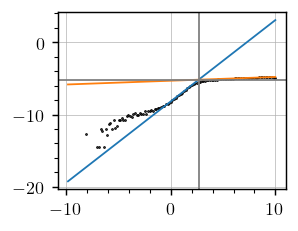

Fit 3,1
2.60+/-0.06 0.00581+/-0.00023
T_e_run = (9.8±0.6)×10³, T_run = (8.4±0.5)×10⁻¹, n_e_run = (7.5±0.4)×10¹⁶


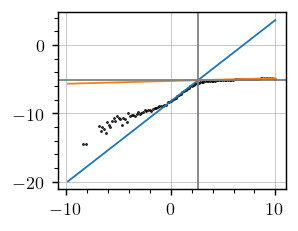

Fit 3,2
3.06+/-0.10 0.00619+/-0.00026
T_e_run = (1.20±0.06)×10⁴, T_run = (1.03±0.05)×10⁰, n_e_run = (7.2±0.4)×10¹⁶


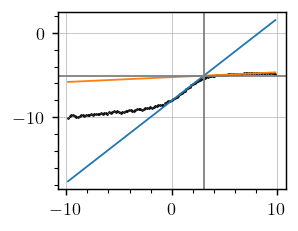

Fit 3,3
1.91+/-0.04 0.001206+/-0.000012
T_e_run = (1.30±0.06)×10⁴, T_run = (1.12±0.05)×10⁰, n_e_run = (1.35±0.03)×10¹⁶


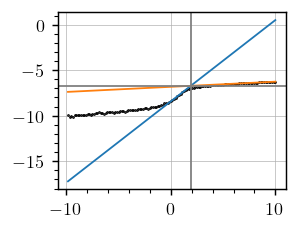

Fit 3,4
2.21+/-0.05 0.003107+/-0.000021
T_e_run = (1.04±0.06)×10⁴, T_run = (8.9±0.5)×10⁻¹, n_e_run = (3.9±0.1)×10¹⁶


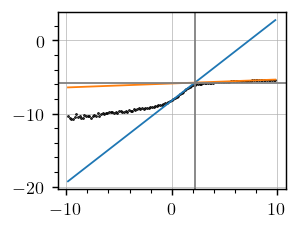

Fit 3,5
2.91+/-0.15 0.00620+/-0.00022
T_e_run = (1.15±0.07)×10⁴, T_run = (9.9±0.6)×10⁻¹, n_e_run = (7.4±0.3)×10¹⁶


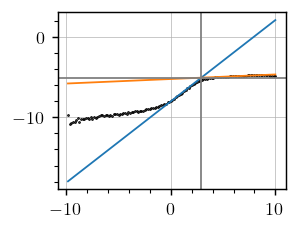

Fit 3,6
3.07+/-0.13 0.0076+/-0.0008
T_e_run = (1.14±0.06)×10⁴, T_run = (9.8±0.5)×10⁻¹, n_e_run = (9.1±0.9)×10¹⁶


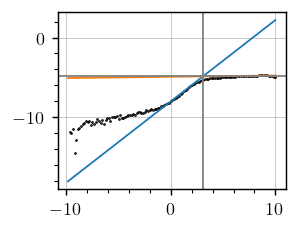

Fit 3,7
2.41+/-0.06 0.00396+/-0.00004
T_e_run = (1.04±0.06)×10⁴, T_run = (8.9±0.5)×10⁻¹, n_e_run = (5.0±0.1)×10¹⁶


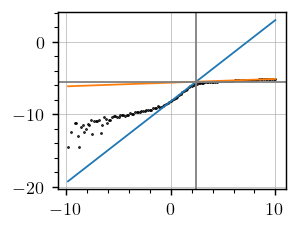

Fit 3,8
2.72+/-0.06 0.00629+/-0.00034
T_e_run = (1.01±0.06)×10⁴, T_run = (8.7±0.5)×10⁻¹, n_e_run = (8.0±0.5)×10¹⁶


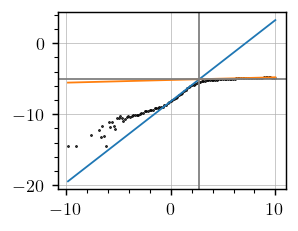

Fit 3,9
2.95+/-0.13 0.0074+/-0.0007
T_e_run = (1.09±0.06)×10⁴, T_run = (9.4±0.6)×10⁻¹, n_e_run = (9.1±0.9)×10¹⁶


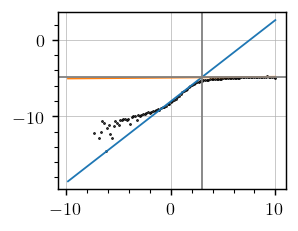

Fit 3,10
2.7+/-0.4 0.00485+/-0.00010
T_e_run = (1.1±0.2)×10⁴, T_run = (9±1)×10⁻¹, n_e_run = (5.9±0.3)×10¹⁶


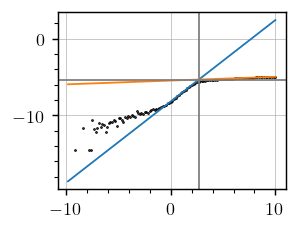

Fit 3,11
2.88+/-0.11 0.0073+/-0.0006
T_e_run = (1.05±0.06)×10⁴, T_run = (9.1±0.5)×10⁻¹, n_e_run = (9.1±0.8)×10¹⁶


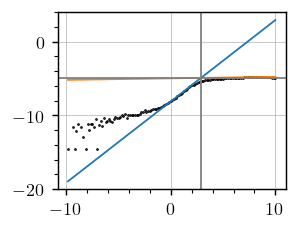

Fit 3,12
2.58+/-0.09 0.00542+/-0.00010
T_e_run = (9.9±0.6)×10³, T_run = (8.6±0.6)×10⁻¹, n_e_run = (6.9±0.2)×10¹⁶


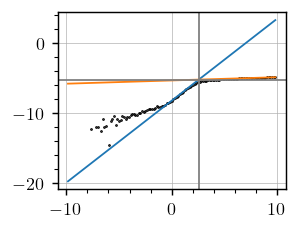

Fit 3,13
2.472+/-0.018 0.00511+/-0.00006
T_e_run = (9.6±0.6)×10³, T_run = (8.2±0.5)×10⁻¹, n_e_run = (6.7±0.2)×10¹⁶


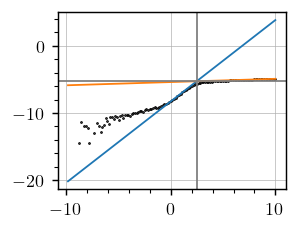

Fit 3,14
2.55+/-0.10 0.00557+/-0.00019
T_e_run = (9.9±0.6)×10³, T_run = (8.5±0.5)×10⁻¹, n_e_run = (7.1±0.3)×10¹⁶


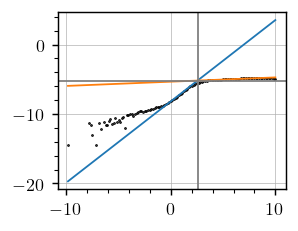

In [7]:
T_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
T = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
n_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))

B_fit_start = np.array(np.ones((len(all_datas), len(all_datas[0])))*0)
B_fit_stop = np.array(np.ones((len(all_datas), len(all_datas[0])))*3.5)
C_fit_start = np.array(np.ones((len(all_datas), len(all_datas[0])))*7)

B_fit_start[0,0] = 1.5
B_fit_stop[0,0] = 3.5
C_fit_start[0,0] = 6
B_fit_start[1,:] = 2
B_fit_start[1,4] = 1.5
B_fit_stop[1,4] = 2.7
B_fit_start[2,:] = 1.5
B_fit_start[3,:] = 1
B_fit_stop[3,:] = 2
B_fit_start[3,1] = 0
C_fit_start[3,2] = 3
B_fit_start[3,3] = 0
B_fit_stop[3,3] = 2
B_fit_start[3,4] = 0.5
B_fit_stop[3,4] = 2
C_fit_start[3,5] = 4
B_fit_start[3,8] = 0
B_fit_stop[3,8] = 2
B_fit_start[3,9] = 1
B_fit_start[3,10] = 0
B_fit_stop[3,10] = 2
B_fit_start[3,12] = 0
B_fit_stop[3,12] = 2
C_fit_start[3,14] = 3

# Determining incertitude
# B_fit_start[2,0] = 0
# B_fit_stop[2,0] = 3.5
# C_fit_start[2,0] = 7

for i, (headers, datas) in enumerate(zip(all_headers, all_datas)):
    for j, (header, data) in enumerate(zip(headers, datas)):
        print(f"Fit {i},{j}")
        p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
        V_in, I_out, I_out_std = data

        dydx = np.gradient(np.log(I_out), V_in)
        threshold = 7e-2
        idx = np.abs(np.diff(dydx, prepend=0)) < threshold
        idx = np.logical_and(idx, V_in > B_fit_start[i,j])
        idx_B = set_all_between(np.logical_and(idx, V_in < B_fit_stop[i,j]))
        idx_C = set_all_between(np.logical_and(idx, V_in > C_fit_start[i,j]))

        coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
        coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
        fitfuncB = np.poly1d(coefsB)
        coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
        coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
        fitfuncC = np.poly1d(coefsC)

        x = np.linspace(V_in[0], V_in[-1])
        plt.scatter(V_in, np.log(I_out), c='k')
        plt.plot(x, fitfuncB(x))
        plt.plot(x, fitfuncC(x))

        V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
        I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
        print(V_sp, I_sp)
        plt.axvline(V_sp.n)
        plt.axhline(umath.log(I_sp).n)

        T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
        T_e_run += ufloat(0, 0.055e4) # incertitude venant de la plage de valeurs possibles pour les fits
        T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
        # TODO: verifier unitées
        n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
        print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
        T_e[i, j] = T_e_run
        T[i, j] = T_run
        n_e[i, j] = n_e_run

        if (i == 3):
            plt.show()
        else:
            plt.gcf().delaxes(plt.gca())

In [8]:
distances_0 = list(map(lambda header: header[1], all_headers[0]))
distances_1 = list(map(lambda header: header[1], all_headers[1]))
distances_2 = list(map(lambda header: header[1], all_headers[2]))
distances_3 = list(map(lambda header: header[1], all_headers[3]))

## Temperature des électrons en fonction de la position pour differentes pressions

In [9]:
p = plt.rcParams
p["figure.figsize"] = (5.75*CM_PER_INCH, 4.5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.21
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.9
p['figure.subplot.bottom'] = 0.22


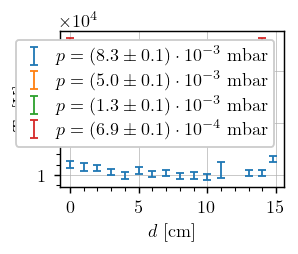

In [10]:
plt.ticklabel_format(axis='both', style='scientific', scilimits=(-3,3))

plt.errorbar(distances_3, nom_vals(T_e[3]), yerr=std_devs(T_e[3]), ls='',
             label=r"$p = (8.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_0, nom_vals(T_e[0]), yerr=std_devs(T_e[0]), ls='',
             label=r"$p = (5.0 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_1, nom_vals(T_e[1]), yerr=std_devs(T_e[1]), ls='',
             label=r"$p = (1.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_2, nom_vals(T_e[2]), yerr=std_devs(T_e[2]), ls='',
             label=r"$p = (6.9\pm 0.1) \cdot 10^{-4}$ mbar")
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$T_e$ [K]')
plt.legend()
plt.savefig("../figures/temperatureK_position.pdf")

### Temperature de électrons (mais en eV)

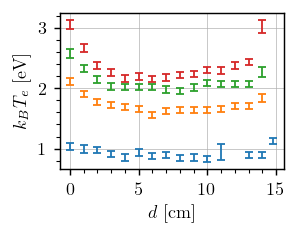

In [11]:
plt.errorbar(distances_3, nom_vals(T[3]), yerr=std_devs(T[3]), ls='',
             label=r"$p = (8.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_0, nom_vals(T[0]), yerr=std_devs(T[0]), ls='',
             label=r"$p = (5.0 \pm 0.1)\cdot 10^{-3}$ mbar")
plt.errorbar(distances_1, nom_vals(T[1]), yerr=std_devs(T[1]), ls='',
             label=r"$p = (1.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_2, nom_vals(T[2]), yerr=std_devs(T[2]), ls='',
             label=r"$p = (6.9\pm 0.1) \cdot 10^{-4}$ mbar")
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$k_B T_e$ [eV]')
# plt.legend()
plt.savefig("../figures/temperatureeV_position.pdf")

## Densité d'electrons en differentes position pour differentes pressions

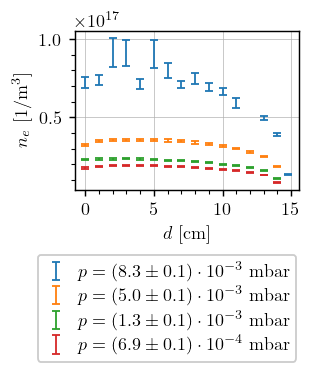

In [16]:
p["figure.figsize"] = (5.75*CM_PER_INCH, 7.5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.21
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.94
p['figure.subplot.bottom'] = 0.525

plt.errorbar(distances_3, nom_vals(n_e[3]), yerr=std_devs(n_e[3]), ls='',
             label=r"$p = (8.3 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_0, nom_vals(n_e[0]), yerr=std_devs(n_e[0]), ls='',
             label=r"$p = (5.0 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_1, nom_vals(n_e[1]), yerr=std_devs(n_e[1]), ls='',
             label=r"$p = (1.3 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_2, nom_vals(n_e[2]), yerr=std_devs(n_e[2]), ls='',
             label=r"$p = (6.9 \pm 0.1) \cdot 10^{-4}$ mbar")
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$n_e$ $[1/$m$^3]$')

lgd = plt.legend(bbox_to_anchor=(1.03, -0.35))
plt.savefig("../figures/density_position.pdf", bbox_extra_artists=(lgd,))